In [ ]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
from data_list_creator import create_data, gate_string_to_list, gate_list_to_string, SNR

#################################################################################################################
gate_string = "(Gx)^49"
nSamples = 2000  #total samples to take for each measurement
nCounts = 1   #total shots to take at one; =nSamples: same noise, probabilities for all repeats; =1, new experiment & noise for each count
time_per_count = 0.016 #seconds
time_units = 1e-3 #seconds. This should be the max resolution you expect to input at any given time (i.e. everthing on the scale of 1e-3 s or more)
res = 1
noise_type='Sine' #Sine, Random Walk, Telegraph
plot_noise=False
walking_amp = 0.0001
low_frequency_noise = [np.round(0.0015*i, 4) for i in range(5)]
#low_frequency_noise = [] #uncomment this to eliminate low_frequency noise
low_frequency_amps = [0.005*i for i in range(len(low_frequency_noise))]
low_frequency_phase = [0]*len(low_frequency_noise)
freq_list=[1.2, 6, 8.4, 9.6] + low_frequency_noise
amp_list=[0.002, 0.002, 0.0015, 0.0015] + low_frequency_amps
phase_list=[0,0,0,0] + low_frequency_phase
telegraph_amp = 0.02
start_f = 0.1
stop_f = 2
fluctuators= 40
add_noise=0.01
    
num_experiments = 20 #how many times you want to run a single set of parameters
variable_params=[31, 47, 63, 79]
param_name = 'L' #'frequency', 'nSamples', 'L', 'amp'


##############################################################################################################
#Don't change anything below this line for regular program operation
freq_list = tuple(freq_list)
amp_list = tuple(amp_list)
phase_list = tuple(phase_list)
num_parameters = len(variable_params) #the number of different parameter sets that will be run num_experiment-times
if param_name == 'frequency' or param_name == 'amp':
    old_variable_params = variable_params
    variable_params = []
    for val in old_variable_params:
        variable_params.append([val])
time_per_sample = nCounts*time_per_count
#2D arrays which will contain the results, data, and top_freqs lists for each parameter & experiment
global_results_list = [0]*num_parameters
global_data_lists = [0]*num_parameters
global_superimposed_lists = [0]*num_parameters
global_snr_list = [0]*num_parameters #contains average SNR for each set of parameters
sig = None


for param_index in range(num_parameters):
    ######This segment finds the appropriate parameter of interest and makes it variable
    if param_name == "frequency": freq_list = variable_params[param_index]
    elif param_name == "nSamples": nSamples = variable_params[param_index]
    elif param_name == "L": 
        gate_list = variable_params[param_index]
        gate_string = "(Gx)^" + str(gate_list)
    elif param_name == "amp": amp_list = variable_params[param_index]
    #################################
    
    results_list = []
    data_lists =[]
    top_freqs = []
    for exp_index in range(num_experiments):
        print("Currently on experiment {}".format(exp_index))
        #Initialize arrays of one-counts per timestep, zero-counts per timstep, the actual timesteps for each, and the probability of getting a 1 for each  
        ones_count_array, zeros_count_array,\
        timestamp_array, probs_array, sig = create_data( \
                                                   time_per_count, nSamples, nCounts, gate_string_to_list(gate_string), time_units,\
                                                   noise_type, walking_amp, telegraph_amp,res, freq_list, \
                                                   amp_list, phase_list, start_f, stop_f,fluctuators,plot_noise,add_noise, sig)
        counts_per_timestep = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
        drifted = drift.do_basic_drift_characterization(ones_count_array, counts=counts_per_timestep, timestep=time_per_sample,timestamps=timestamp_array, verbosity = 0)
        results_list.append(drifted)
        
        #analyze the frequency-power spectrum
        frequencies = list(drifted.frequencies)
        power_spectrum = list(drifted.pspepo_power_spectrum[0,0,1,:])
        grouped = []
        for i in range(len(frequencies)):
            grouped.append((frequencies[i], power_spectrum[i]))
        sorted_groups = sorted(grouped, key=lambda tup: tup[1], reverse=True)
        num_points = 5
        exp_data = ()
        for i in range(num_points):
            exp_data = exp_data + ("#{}: {:.3f} Hz".format(i+1, sorted_groups[i][0]),)
            if i == 0:
                top_freqs.append(sorted_groups[i][0])
        data_lists.append(exp_data)
    
    global_results_list[param_index] = results_list
    global_data_lists[param_index] = data_lists


C:\Users\GA28573\Documents\pyGSTi-master\packages\pygsti\tools\matrixtools.py:23: UserWarning: Could not import Cython extension - falling back to slower pure-python routines
  _warnings.warn("Could not import Cython extension - falling back to slower pure-python routines")


Currently on experiment 0
INITIALIZING NEW NOISE
Currently on experiment 1
REUSING NOISE OBJECT
Currently on experiment 2
REUSING NOISE OBJECT


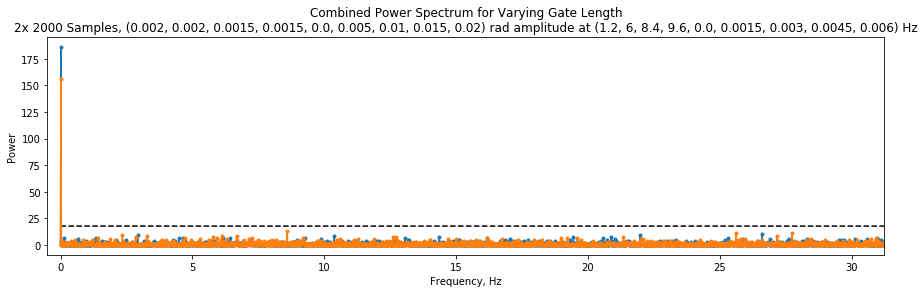

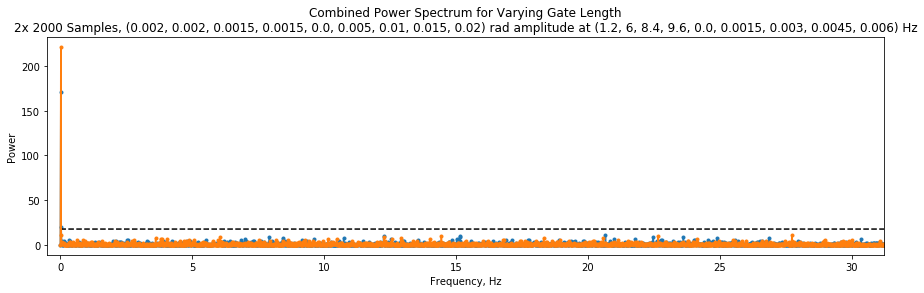

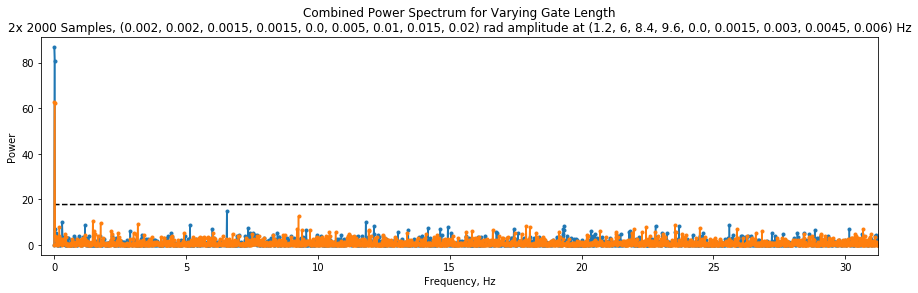

In [8]:

for results_list in global_results_list:   
    index = global_results_list.index(results_list)       
    if param_name == "frequency": 
        freq_list = variable_params[index] #not actually a list, this is just the naming convention
        title_string = "Combined Power Spectrum for Varying Drift Frequencies\n{}x {} Samples of {}, {} rad amplitude" \
            .format(num_experiments, nSamples, gate_string, amp_list[0])
        x_string = "Frequency of Drift, Hz"    
    elif param_name == "nSamples": 
        nSamples = variable_params[index]
        title_string = "Combined Power Spectrum for Varying Sample Size\n{}x Experiments of {}, {} rad amplitude at {} Hz" \
            .format(num_experiments, gate_string, amp_list, freq_list)
        x_string = "Number of Samples, each with {} count and {} s".format(nCounts, time_per_sample)
    elif param_name == "L": 
        gate_string = variable_params[index]
        title_string = "Combined Power Spectrum for Varying Gate Length\n{}x {} Samples, {} rad amplitude at {} Hz" \
            .format(num_experiments, nSamples, amp_list, freq_list)
        x_string = "Gate Sequence Length"
    elif param_name == "amp": 
        amp_list = variable_params[index] #not actually a list, just convention
        title_string = "Combined Power Spectrum for Varying Sine Error Amplitude\n{}x {} Samples of {}, error at {} Hz" \
            .format(num_experiments, nSamples, gate_string, freq_list[0])
        x_string = "Drift Amplitude, radians"
    
    fig = plt.figure(figsize=(15,4))
    confidence_is_plotted = False
    for results in results_list:
        plt.plot(results.frequencies,results.pspepo_power_spectrum[0,0,1,:],ls="solid",marker='.')
        if not(confidence_is_plotted):plt.plot(results.frequencies,results.pspepo_significance_threshold_1test*np.ones(results.number_of_timesteps),'k--', 
                  label=str(results.confidence)+' confidence single-test significance threshold')
        confidence_is_plotted = True
    plt.xlabel("Frequency, Hz")
    plt.xlim((-0.5,results_list[0].frequencies[-1]))
    plt.ylabel("Power")
    plt.title(title_string)
    plt.show()


!!!!!! Power is averaged here! Previous saved versions just have the powers summed!
Mean power is 0.9999999999894514


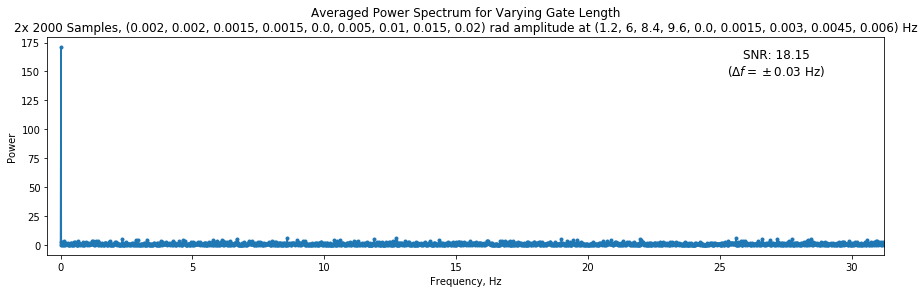

[18.151420036749787, 0, 0]
!!!!!! Power is averaged here! Previous saved versions just have the powers summed!
Mean power is 0.9999999999905264


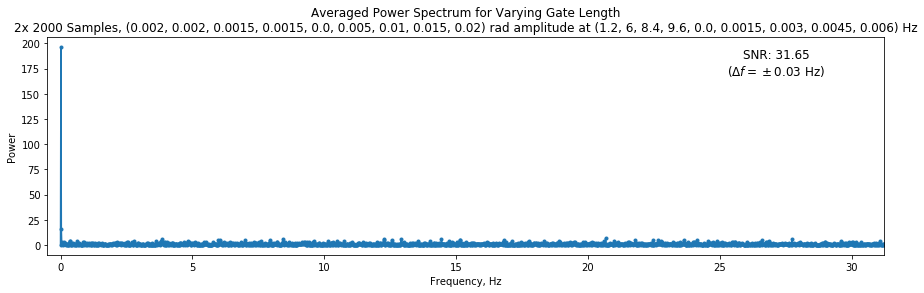

[18.151420036749787, 31.654329130962985, 0]
!!!!!! Power is averaged here! Previous saved versions just have the powers summed!
Mean power is 0.9999999999881551


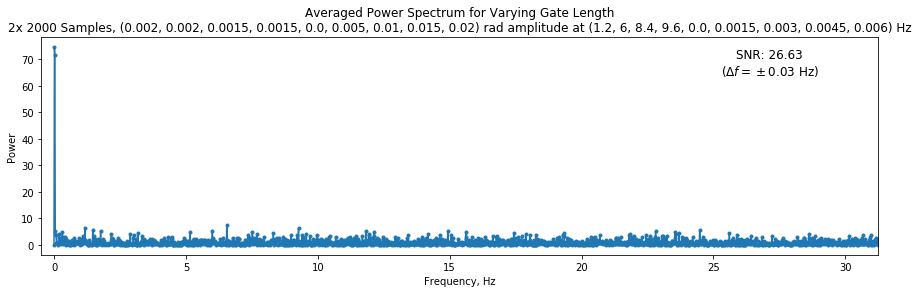

[18.151420036749787, 31.654329130962985, 26.627353006748557]


In [9]:
global_snr_list = [0]*num_parameters
for results_list in global_results_list:
    index = global_results_list.index(results_list) 
    if param_name == "frequency": 
        freq_list = variable_params[index] #not actually a list, this is just the naming convention
        title_string = "Superimposed Power Spectrum for Varying Drift Frequencies\n{}x {} Samples of {}, {} rad amplitude" \
            .format(num_experiments, nSamples, gate_string, amp_list[0])
        x_string = "Frequency of Drift, Hz"    
    elif param_name == "nSamples": 
        nSamples = variable_params[index]
        title_string = "Superimposed Power Spectrum for Varying Sample Size\n{}x Experiments of {}, {} rad amplitude at {} Hz" \
            .format(num_experiments, gate_string, amp_list, freq_list)
        x_string = "Number of Samples, each with {} count and {} s".format(nCounts, time_per_sample)
    elif param_name == "L": 
        gate_string = variable_params[index]
        title_string = "Superimposed Power Spectrum for Varying Gate Length\n{}x {} Samples, {} rad amplitude at {} Hz" \
            .format(num_experiments, nSamples, amp_list, freq_list)
        x_string = "Gate Sequence Length"
    elif param_name == "amp": 
        amp_list = variable_params[index] #not actually a list, just convention
        title_string = "Superimposed Power Spectrum for Varying Sine Error Amplitude\n{}x {} Samples of {}, error at {} Hz" \
            .format(num_experiments, nSamples, gate_string, freq_list[0])
        x_string = "Drift Amplitude, radians"
        
    superimposed_power_spectrum = np.zeros(len(results_list[0].pspepo_power_spectrum[0,0,1,:]))
    superimposed_frequencies = results_list[0].frequencies
    
    for result in results_list:
        for index2 in range(len(superimposed_power_spectrum)):
            power = result.pspepo_power_spectrum[0,0,1,:][index2]
            superimposed_power_spectrum[index2] += power
    
    averaged = True #here I'm dividing the superimposed power by the number of experiments to get an average
    if averaged:
        superimposed_power_spectrum = superimposed_power_spectrum/num_experiments
        print("!!!!!! Power is averaged here! Previous saved versions just have the powers summed!")
        title_string = "Averaged " + title_string[13:]
    global_superimposed_lists[index] = superimposed_power_spectrum
        
    
    snr_bandwidth = 0.03
    snr_freq_list = [1.2, 6, 8.4, 9.6]
    print("Mean power is {}".format(np.mean(superimposed_power_spectrum)))
    avg_SNR = SNR(superimposed_frequencies, superimposed_power_spectrum, snr_freq_list, snr_bandwidth)   
    global_snr_list[index] = avg_SNR
    fig = plt.figure(figsize=(15,4))
    plt.plot(superimposed_frequencies, superimposed_power_spectrum,ls="solid",marker='.')
    plt.xlabel("Frequency, Hz")
    plt.xlim((-0.5,superimposed_frequencies[-1]))
    plt.ylabel("Power")
    plt.title(title_string)
    plt.figtext(0.8, 0.75,"SNR: {:.2f}\n$(\Delta f = \pm{}$ Hz)".format(avg_SNR,snr_bandwidth), wrap=True,
            horizontalalignment='center', fontsize=12)
    plt.show()
    
    print(global_snr_list)

!!!!!! Power is averaged here! Previous saved versions just have the powers summed!
True


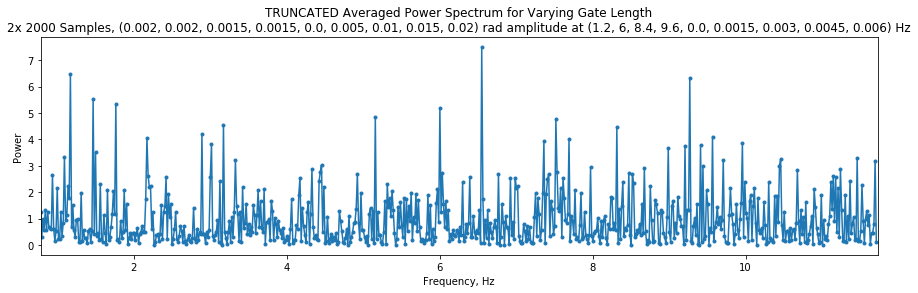

!!!!!! Power is averaged here! Previous saved versions just have the powers summed!
True


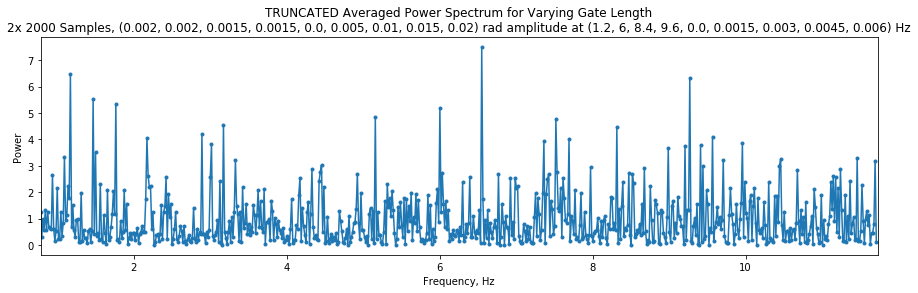

!!!!!! Power is averaged here! Previous saved versions just have the powers summed!
True


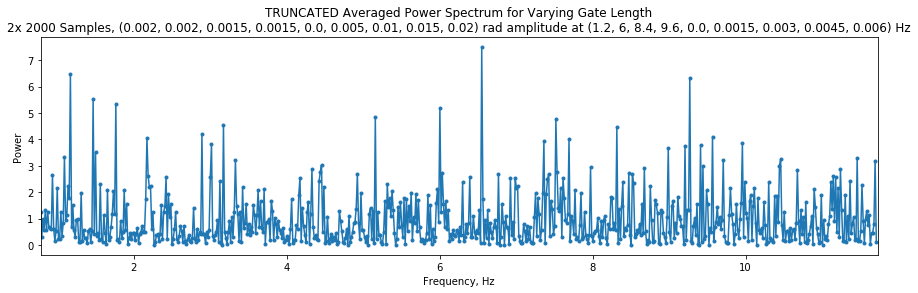

In [10]:
##Plotting the truncated, superimposed power spectrum
plt.figure(figsize=(15,4))
for results_list in global_results_list:
    index = global_results_list.index(results_list)       
    if param_name == "frequency": 
        title_string = "Superimposed Power Spectrum for Varying Drift Frequencies\n{}x {} Samples of {}, {} rad amplitude" \
            .format(num_experiments, nSamples, gate_string, amp_list[0])   
    elif param_name == "nSamples": 
        title_string = "Superimposed Power Spectrum for Varying Sample Size\n{}x Experiments of {}, {} rad amplitude at {} Hz" \
            .format(num_experiments, gate_string, amp_list, freq_list)
    elif param_name == "L": 
        title_string = "Superimposed Power Spectrum for Varying Gate Length\n{}x {} Samples, {} rad amplitude at {} Hz" \
            .format(num_experiments, nSamples, amp_list, freq_list)
    elif param_name == "amp": 
        title_string = "Superimposed Power Spectrum for Varying Sine Error Amplitude\n{}x {} Samples of {}, error at {} Hz" \
            .format(num_experiments, nSamples, gate_string, freq_list[0])
    
    superimposed_power_spectrum = np.zeros(len(results_list[0].pspepo_power_spectrum[0,0,1,:]))
    superimposed_frequencies = results_list[0].frequencies
    
    for result in results_list:
        for index3 in range(len(superimposed_power_spectrum)):
            power = result.pspepo_power_spectrum[0,0,1,:][index3]
            superimposed_power_spectrum[index3] += power
    
    averaged = True #here I'm dividing the superimposed power by the number of experiments to get an average
    if averaged:
        superimposed_power_spectrum = superimposed_power_spectrum/num_experiments
        #print("!!!!!! Power is averaged here! Previous saved versions just have the powers summed!")
        title_string = "Averaged " + title_string[13:]
    
    
    mindex = 50
    maxdex = 700
    
    
    plt.plot(superimposed_frequencies[mindex:maxdex], superimposed_power_spectrum[mindex:maxdex],ls="solid",marker='.',
            label=variable_params[index])

plt.xlabel("Frequency, Hz")
plt.xlim((superimposed_frequencies[mindex],superimposed_frequencies[maxdex]))
plt.ylabel("Power")
plt.title("TRUNCATED " + title_string)
plt.legend(title=param_name)

plt.show()


[31, 47, 63]
[18.151420036749787, 31.654329130962985, 26.627353006748557]


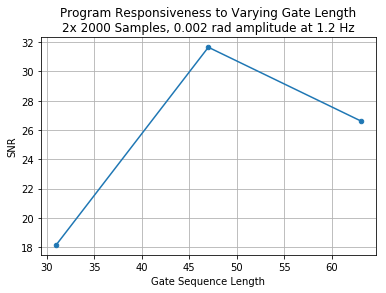

In [11]:
#######here i'll show the results over the varied parameter
index = global_results_list.index(results_list)
if param_name == "frequency": 
    freq_list = variable_params[index] #not actually a list, this is just the naming convention
    title_string = "Program Responsiveness to Varying Drift Frequencies\n{}x {} Samples of {}, {} rad amplitude" \
        .format(num_experiments, nSamples, gate_string, amp_list[0])
    x_string = "Frequency of Drift, Hz"    
elif param_name == "nSamples": 
    nSamples = variable_params[index]
    title_string = "Program Responsiveness to Varying Sample Size\n{}x Experiments of {}, {} rad amplitude at {} Hz" \
        .format(num_experiments, gate_string, amp_list[0], freq_list[0])
    x_string = "Number of Samples, each with {} count and {} s".format(nCounts, time_per_sample)
elif param_name == "L": 
    gate_string = variable_params[index]
    title_string = "Program Responsiveness to Varying Gate Length\n{}x {} Samples, {} rad amplitude at {} Hz" \
        .format(num_experiments, nSamples, amp_list[0], freq_list[0])
    x_string = "Gate Sequence Length"
elif param_name == "amp": 
    amp_list = variable_params[index] #not actually a list, just convention
    title_string = "Program Responsiveness to Varying Sine Error Amplitude\n{}x {} Samples of {}, error at {} Hz" \
        .format(num_experiments, nSamples, gate_string, freq_list[0])
    x_string = "Drift Amplitude, radians"
    
print(variable_params)
print(global_snr_list)
    
plt.plot(variable_params,global_snr_list, marker='.',markersize="9")
plt.grid()
plt.xlabel(x_string)
plt.title(title_string)
plt.ylabel("SNR")
plt.show()
    